In [1]:
! pip install -Uqq duckduckgo_search

In [2]:
from fastcore.all import *
from duckduckgo_search import ddg_images
def search_images(term, max_images=200):    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls=search_images('dog photos', max_images=1)
urls[0]

'https://static.stacker.com/s3fs-public/2019-01/shutterstock_136832084_2.jpg'

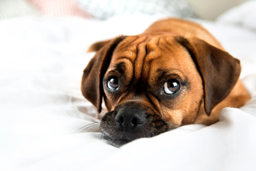

In [4]:
from fastdownload import download_url
dest='dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

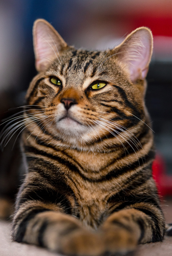

In [5]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

In [6]:
searches = 'cat','dog'
path = Path('dog_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results=search_images(f'{o} photo')
    download_images(dest, urls=results[:200])
    resize_images(path/o, max_size=400, dest=path/o)
     

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
fns=get_image_files(path)
fns

(#4113) [Path('dog_or_not/dog/1e00d0ac-3f84-4b8b-9653-038fe5eaca68.jpg'),Path('dog_or_not/dog/97dfe6d0-6193-400c-b122-21abe0c0ea9d.jpg'),Path('dog_or_not/dog/dc0294ad-c273-4246-803a-b556ae9f5f23.jpg'),Path('dog_or_not/dog/a6105f6b-b24b-4b63-ba82-9b93568e7fc3.jpg'),Path('dog_or_not/dog/693d07dc-4678-4ec6-8d1e-6a9ac37a388e.jpg'),Path('dog_or_not/dog/8d74c3a4-87c9-4c18-8919-679c09142c80.jpg'),Path('dog_or_not/dog/676c064d-5ce4-468b-8c83-41a9d18cd9a8.jpg'),Path('dog_or_not/dog/53c89149-1a18-4510-b214-a80601991afa.jpg'),Path('dog_or_not/dog/6257eb0f-4bab-4113-b052-fb76936364f1.jpg'),Path('dog_or_not/dog/88a0dd65-6202-444f-bca2-d41483a5bdc5.jpg')...]

In [8]:
failed=verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

In [9]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(225, min_scale=0.3)])

In [10]:
dls=pets.dataloaders(path)

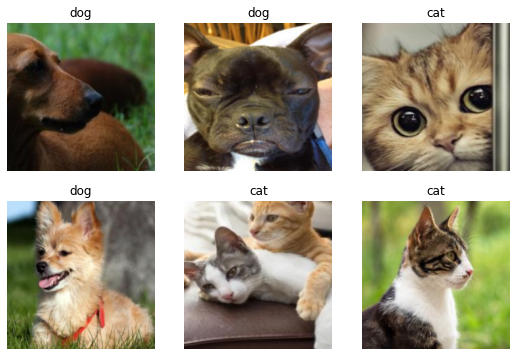

In [11]:
dls.show_batch(max_n=6, nrows=2)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.249418,0.026686,0.006090,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.059835,0.023406,0.002436,00:25
1,0.042467,0.002798,0.000000,00:25
2,0.025705,0.000324,0.000000,00:25


## Clean Data

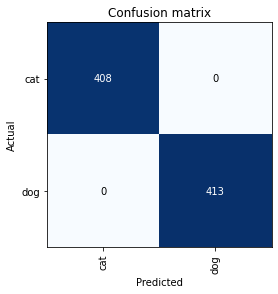

In [13]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

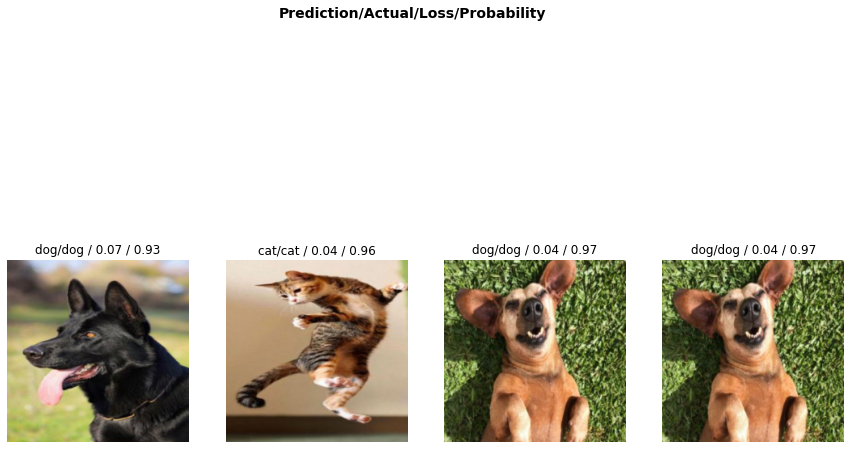

In [14]:
interp.plot_top_losses(k=4, nrows=1,figsize=(15, 10))

In [15]:
from fastai.vision.widgets import *
cleaner=ImageClassifierCleaner(learn)
cleaner

In [17]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx in cleaner.change(): shutil.move(str(clean.fns[idx], path/cat))

## Export Model

In [20]:
learn.export('model.pkl')